## Evaluate final model

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import re
import json
import statistics

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline


/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load datasets

In [15]:
## RAW
train_df_raw= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw_final.csv')
test_df_raw= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw_final.csv')
val_df_raw= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw_final.csv')

## set Date-Time as index
train_df_raw.set_index('Date_Time', inplace =True)
train_df_raw.index = pd.to_datetime(train_df.index)
test_df_raw.set_index('Date_Time', inplace =True)
test_df_raw.index = pd.to_datetime(test_df.index)
val_df_raw.set_index('Date_Time', inplace =True)
val_df_raw.index = pd.to_datetime(val_df.index)

## get mean and sd to de-standarize
train_mean = train_df_raw.mean()
train_std = train_df_raw.std()

In [19]:
## Standarized:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_stand_final.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_stand_final.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_stand_final.csv')

## set Date-Time as index
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [13]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(test_df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(test_df.columns))) 

### Generate windows again

In [20]:
### Generate the window data again
## get functions
%run model_utils.ipynb

# set fixed parameters (same as in the model)
batch_size = 256
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
input_width = 48*time_steps
OUT_STEPS =24*time_steps

window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)

### Load pre-run model

In [5]:
## load model back
from tensorflow import keras
path = 'data/PROCESSED/MODEL_OUTPUTS'
model = keras.models.load_model(f'{path}/final_model_rep1_zero')

In [21]:
for inputs, labels in window.test.take(4):  # iterate over batches
    numpy_labels = labels.numpy() ### get labels
    numpy_inputs = inputs.numpy() ### get inputs
    preds = model(numpy_inputs) ### make prediction from trained model
    numpy_preds = preds.numpy() 

In [8]:
real_names = {'ATAvg_AJS': 'Colegio A.J. Sucre',
              'ATAvg_JAl': 'Colegio J. Álvarez',
              'ATAvg_aer': 'Aeropuerto Ambato',
              'ATAvg_ban': 'Baños',
              'ATAvg_cal': 'Calamaca Convenio',
              'ATAvg_chi': 'Chiquiurco',
              'ATAvg_cun': 'Hacienda Cunchibamba',
              'ATAvg_gua': 'Estación Guadalupe',
              'ATAvg_mul': 'Mula Corral',
              'ATAvg_pam': 'Pampas de Salasaca',
              'ATAvg_pfc': 'Pedro Fermín Cevallos',
              'ATAvg_pis': 'Pisayambo-Talalag',
              'ATAvg_qui': 'Quisapincha',
              'ATAvg_tas': 'Estación de Tasinteo',
              'RHAvg_AJS': 'Colegio A.J. Sucre',
              'RHAvg_JAl': 'Colegio J. Álvarez',
              'RHAvg_aer': 'Aeropuerto Ambato',
              'RHAvg_ban': 'Baños',
              'RHAvg_cal': 'Calamaca Convenio',
              'RHAvg_chi': 'Chiquiurco',
              'RHAvg_cun': 'Hacienda Cunchibamba',
              'RHAvg_gua': 'Estación Guadalupe',
              'RHAvg_mul': 'Mula Corral',
              'RHAvg_pam': 'Pampas de Salasaca',
              'RHAvg_pfc': 'Pedro Fermín Cevallos',
              'RHAvg_pis': 'Pisayambo-Talalag',
              'RHAvg_qui': 'Quisapincha',
              'RHAvg_tas': 'Estación de Tasinteo'}

In [8]:
n = 5

<function matplotlib.pyplot.show(*args, **kw)>

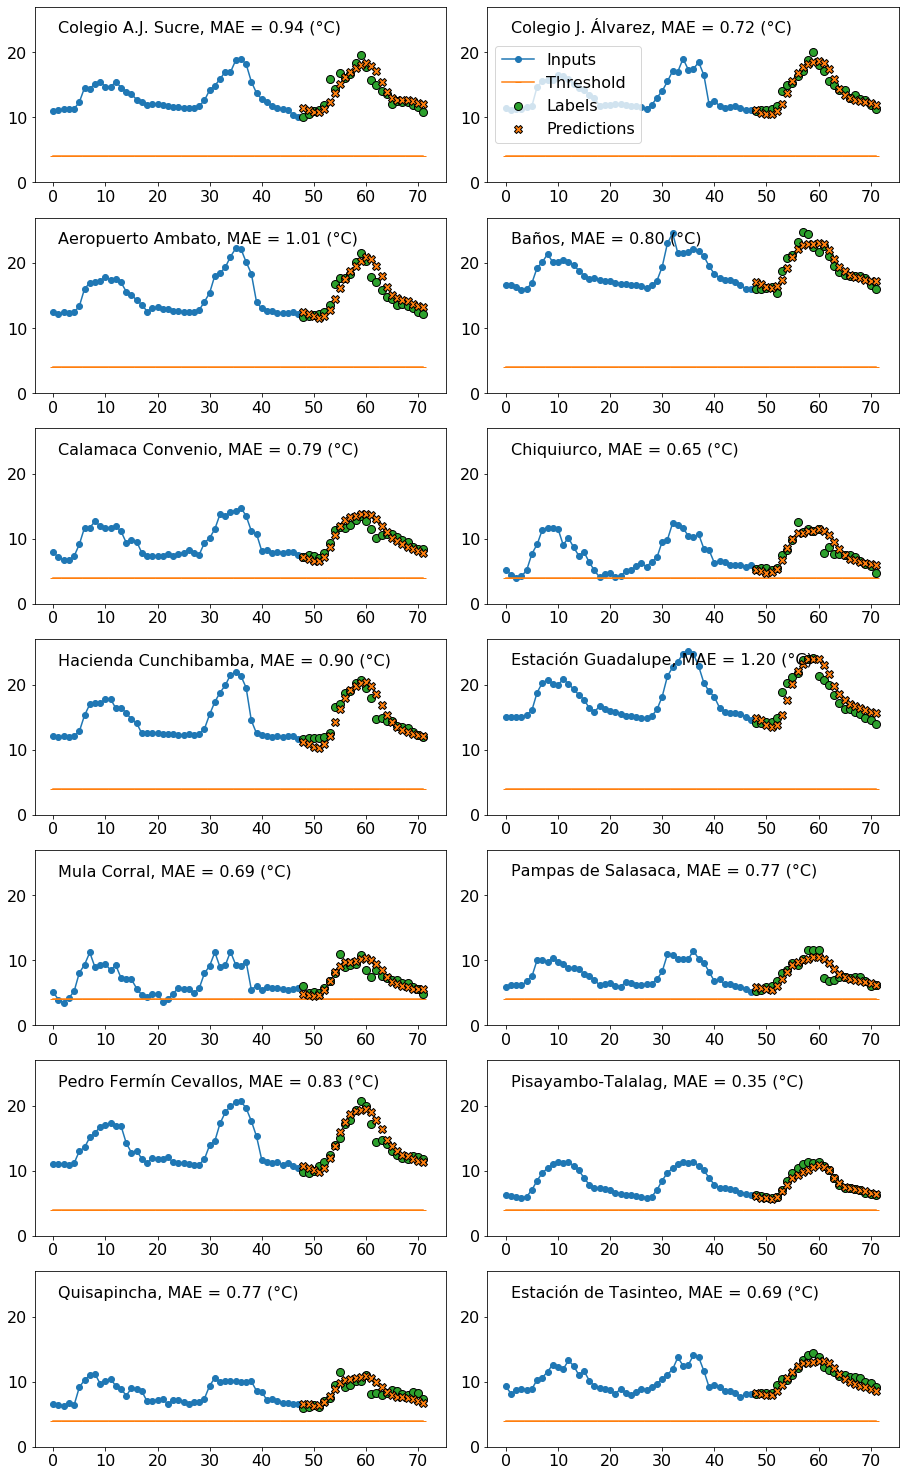

In [22]:
var = 'ATAvg'
degree_sign = u'\N{DEGREE SIGN}'
units = f'({degree_sign}C)'
r = re.compile(f'{var}.*') # only csv files
variables = sorted(list(filter(r.match, list(test_df.columns))))

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(7, 2, figsize = (15, 25))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)
                    
for i, ax in enumerate(axes.flatten()):
    plot_col_index = test_df.columns.get_loc(variables[i])
    batch_pred =numpy_preds[n,:,plot_col_index]*train_std[plot_col_index] + train_mean[plot_col_index]
    batch_label = numpy_labels[n,:,plot_col_index]*train_std[plot_col_index] + train_mean[plot_col_index]
    batch_input = numpy_inputs[n,:,plot_col_index]*train_std[plot_col_index] + train_mean[plot_col_index]
    mae = round(mean_absolute_error(batch_label, batch_pred),2)
    
    inputs, labels, preds = batch_input, batch_label, batch_pred
    ax.plot(np.array(range(0,48)), inputs,
         label='Inputs', marker='o', zorder=-10)

    ax.scatter(np.array(range(48,72)), labels,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)

    ax.scatter(np.array(range(48,72)), preds,
              marker='X', edgecolors='k', label='Predictions',
              c='#ff7f0e', s=64)
    ax.plot(np.array(range(0,72)), np.repeat(4,72),
         label='Threshold', marker='_', zorder=-10)
    ax.text(1,23, f'{real_names[variables[i]]}, MAE = {mae:.2f} {units}')
    ax.set_ylim((0,27))
    if i == 1:
        ax.legend(loc= 'center left')
plt.show
#plt.savefig(f'{path}/{station}_prediction_example_{var}_{n}.png',dpi=100,bbox_inches='tight')        

<function matplotlib.pyplot.show(*args, **kw)>

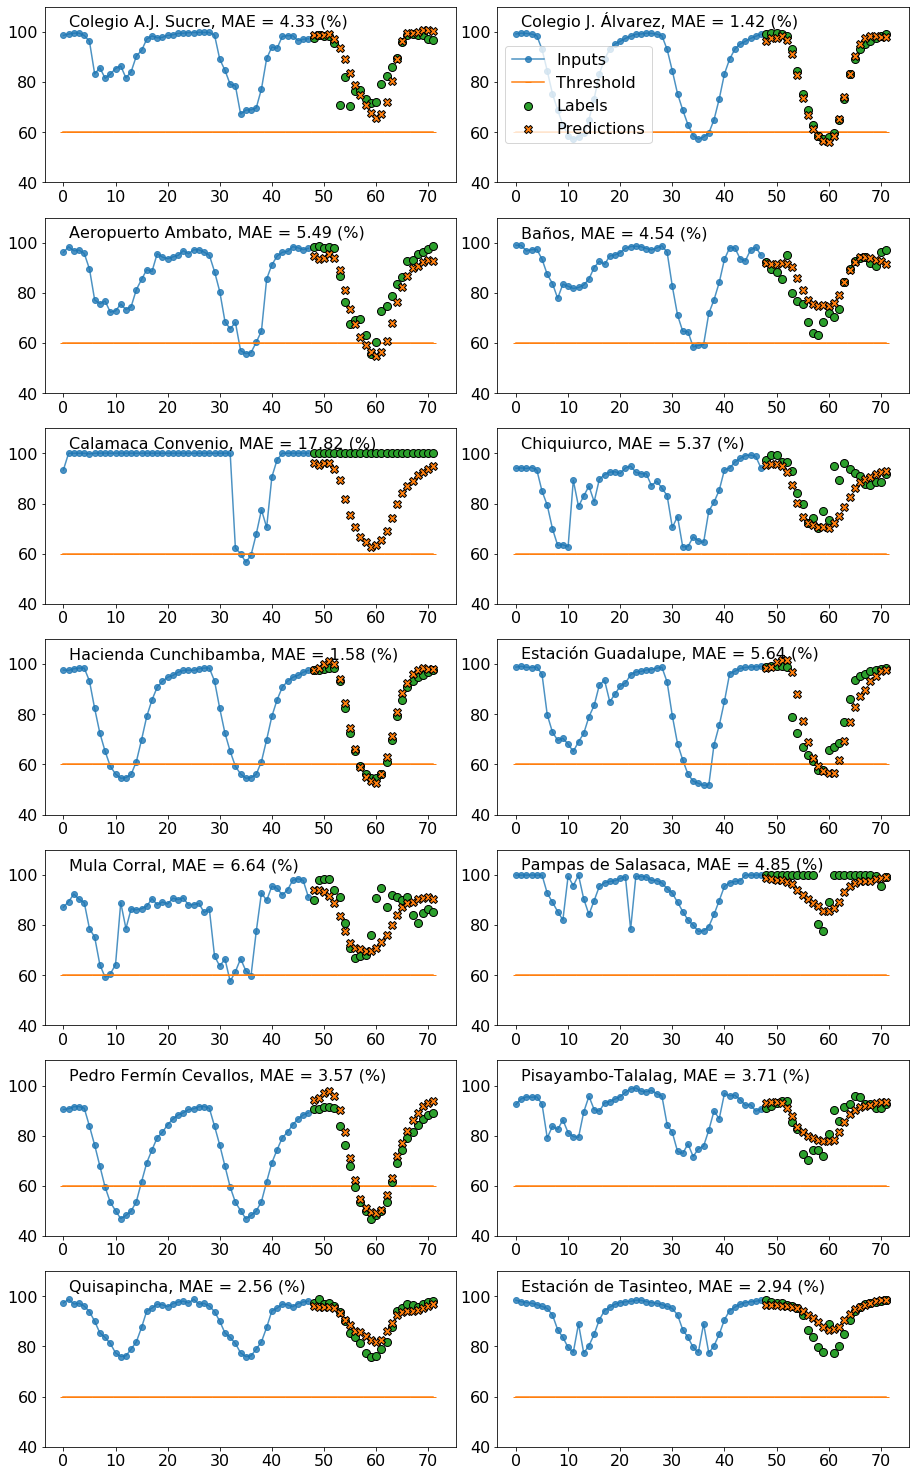

In [23]:
var = 'RHAvg'
units = f'(%)'
r = re.compile(f'{var}.*') # only csv files
variables = sorted(list(filter(r.match, list(test_df.columns))))

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(7, 2, figsize = (15, 25))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)

for i, ax in enumerate(axes.flatten()):
    plot_col_index = test_df.columns.get_loc(variables[i])
    batch_pred =numpy_preds[n,:,plot_col_index]*train_std[plot_col_index] + train_mean[plot_col_index]
    batch_label = numpy_labels[n,:,plot_col_index]*train_std[plot_col_index] + train_mean[plot_col_index]
    batch_input = numpy_inputs[n,:,plot_col_index]*train_std[plot_col_index] + train_mean[plot_col_index]
    mae = round(mean_absolute_error(batch_label, batch_pred),2)
    
    inputs, labels, preds = batch_input, batch_label, batch_pred
    ax.plot(np.array(range(0,48)), inputs,
         label='Inputs', marker='o', zorder=-10,alpha =0.8)

    ax.scatter(np.array(range(48,72)), labels,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)

    ax.scatter(np.array(range(48,72)), preds,
              marker='X', edgecolors='k', label='Predictions',
              c='#ff7f0e', s=64)
    ax.plot(np.array(range(0,72)), np.repeat(60,72),
         label='Threshold', marker='_', zorder=-10)
    ax.text(1,102, f'{real_names[variables[i]]}, MAE = {mae:.2f} {units}')
    ax.set_ylim((40,110))
    if i == 1:
        ax.legend(loc= 'center left')
plt.show
#plt.savefig(f'{path}/{station}_prediction_example_{var}_{n}.png',dpi=100,bbox_inches='tight') 

## Get final MAE for each station (instead of by time)

In [2]:
path = 'data/PROCESSED/MODEL_OUTPUTS'
rep1 = pd.read_csv(f'{path}/all_lstm-256-var-mean-lr-adam-init-zeros_60m_w48_24_20_1performance_times.csv')
rep2 = pd.read_csv(f'{path}/all_lstm-256-var-mean-lr-adam-init-zeros_60m_w48_24_20_2performance_times.csv')
rep3 = pd.read_csv(f'{path}/all_lstm-256-var-mean-lr-adam-init-zeros_60m_w48_24_20_3performance_times.csv')

In [3]:
rep1['rep']='rep1'
rep2['rep']='rep2'
rep3['rep']='rep3'

In [4]:
results = rep1.append(rep2).append(rep3)

In [5]:
variables = results['Unnamed: 1'].unique()
variables

array(['ATAvg_gua', 'ATAvg_ban', 'ATAvg_aer', 'ATAvg_qui', 'ATAvg_chi',
       'ATAvg_AJS', 'ATAvg_JAl', 'ATAvg_pfc', 'ATAvg_cal', 'ATAvg_mul',
       'ATAvg_pam', 'ATAvg_tas', 'ATAvg_pis', 'ATAvg_cun', 'RHAvg_gua',
       'RHAvg_ban', 'RHAvg_aer', 'RHAvg_qui', 'RHAvg_chi', 'RHAvg_AJS',
       'RHAvg_JAl', 'RHAvg_pfc', 'RHAvg_cal', 'RHAvg_mul', 'RHAvg_pam',
       'RHAvg_tas', 'RHAvg_pis', 'RHAvg_cun'], dtype=object)

In [6]:
station_MAE = []
std_MAE = []
for a,var in enumerate(variables):
    df = results[results['Unnamed: 1'] == variables[a]]
    rep_MAE=[]
    for rep in df.rep.unique():
        val_index =df.index[df['rep']==rep].values[0]
        avg_rep = statistics.mean(json.loads(df[df['rep']==rep].mae[val_index]))
        rep_MAE.append(avg_rep)
    station_MAE.append(statistics.mean(rep_MAE))
    std_MAE.append(np.std(rep_MAE))
d={'variables': variables, 'avg_MAE': station_MAE, 'std_MAE':std_MAE}
mae = pd.DataFrame(data = d)

In [55]:
mae.sort_values(by='avg_MAE').to_csv(f'{path}/all_MAE_by_station')

In [9]:
mae['station']=mae['variables']
mae['station'] =mae['station'].replace(real_names)
l =['ATAvg']*14
l.extend(['RHAvg']*14)
mae['var']=l
mae=mae.sort_values(by='station')

In [10]:
mae.station.unique()

array(['Aeropuerto Ambato', 'Baños', 'Calamaca Convenio', 'Chiquiurco',
       'Colegio A.J. Sucre', 'Colegio J. Álvarez', 'Estación Guadalupe',
       'Estación de Tasinteo', 'Hacienda Cunchibamba', 'Mula Corral',
       'Pampas de Salasaca', 'Pedro Fermín Cevallos', 'Pisayambo-Talalag',
       'Quisapincha'], dtype=object)

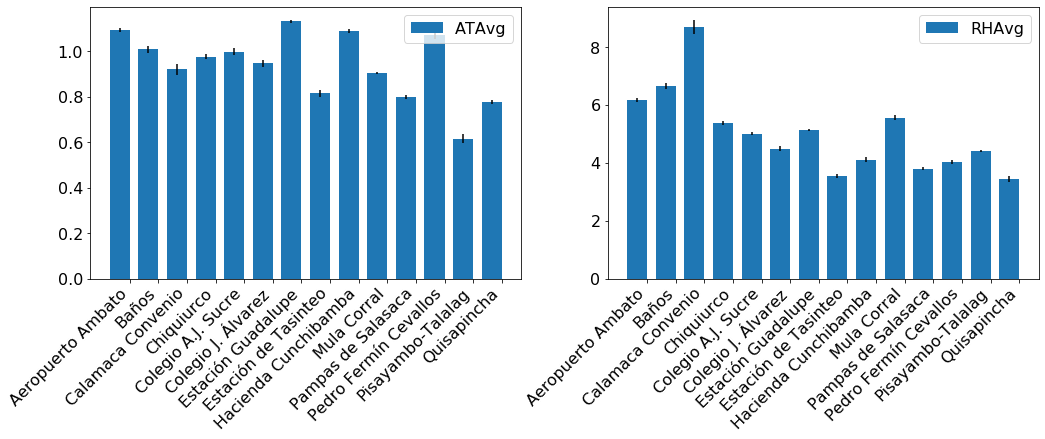

In [33]:
y_pos = np.arange(len(mae.station.unique())) # the x locations for the groups
width = 0.7 # the width of the bars

fig, axes = plt.subplots(1,2,figsize = (17,5))
plt.rcParams.update({'font.size': 16})
#plt.rcParams['figure.facecolor'] = 'white'
for i,ax in enumerate(axes.flatten()):
        ax.bar(y_pos - width/2,
               mae[(mae['var']==mae['var'].unique()[i])]['avg_MAE'], 
               width, 
               yerr=mae[(mae['var']==mae['var'].unique()[i])]['std_MAE'],
               label=mae['var'].unique()[i])
        ax.set_xticks(ticks=y_pos)
        ax.set_xticklabels(labels=mae.station.unique(),rotation = 45, ha="right")
        ax.legend()
plt.savefig('data/PROCESSED/MODEL_OUTPUTS/all_MAE_by_station.png', dpi = 100,bbox_inches='tight')

## Other figures

### FFT

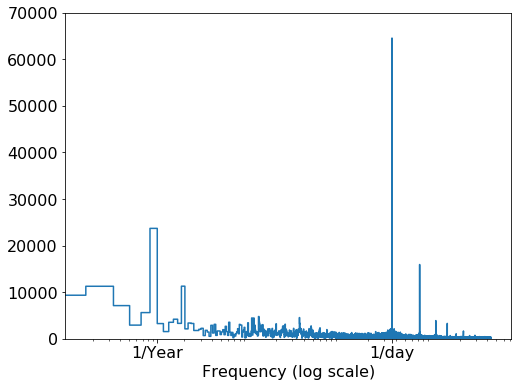

In [75]:
all_vars = train_df_raw.append(val_df_raw).append(test_df_raw)

fft = tf.signal.rfft(all_vars['ATAvg_cal'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(all_vars['ATAvg_mul'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 6))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 70000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.xlabel('Frequency (log scale)')
plt.savefig(f'{path}/fft.png', dpi = 100,bbox_inches='tight')

### Histogram of variables

In [35]:
df= pd.read_csv('data/PROCESSED/STATIONS_CLEAN/banos_validation.csv')
df_reduced =df[0::12] ## take a sample every hour

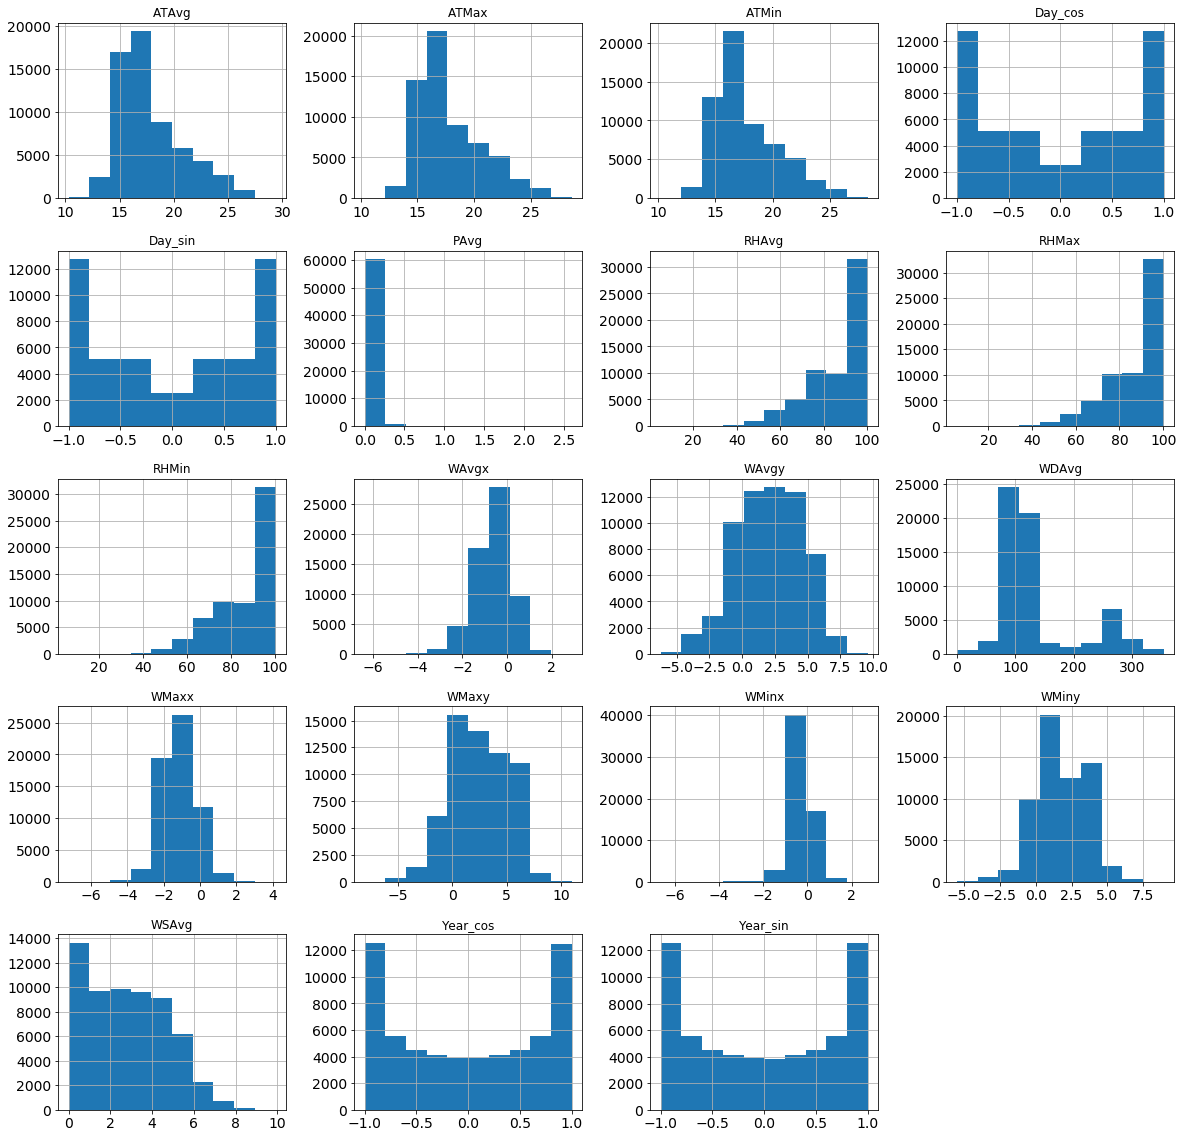

In [8]:
df_reduced.hist(figsize=(20, 20),xlabelsize =14, ylabelsize =14)
plt.savefig(f'data/PROCESSED/STATIONS_CLEAN/banos_histogram.png', dpi = 100,bbox_inches='tight')

In [5]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-01-11 00:00:00,16.83,16.89,16.78,79.49,79.22,79.97,0.0,161.69,2.64,-2.506339,0.829378,-1.019428,0.995687,-0.226449,0.550224,-8.709422e-12,1.000000,0.180875,0.983506
1,2013-01-11 00:05:00,16.89,17.00,16.81,79.49,78.79,80.02,0.0,142.73,2.24,-1.782571,1.356481,-1.019428,0.995687,-0.226449,0.550224,2.181489e-02,0.999762,0.180934,0.983495
2,2013-01-11 00:10:00,16.98,17.07,16.89,78.35,77.66,78.96,0.0,57.90,2.60,1.381636,2.202517,-1.019428,0.995687,-0.226449,0.550224,4.361939e-02,0.999048,0.180993,0.983484
3,2013-01-11 00:15:00,16.93,16.97,16.87,77.86,76.72,78.37,0.0,42.07,3.01,2.234404,2.016814,-1.019428,0.995687,-0.226449,0.550224,6.540313e-02,0.997859,0.181052,0.983474
4,2013-01-11 00:20:00,17.09,17.37,16.80,77.22,76.70,78.00,0.0,142.72,2.12,-1.686852,1.284107,-1.019428,0.995687,-0.226449,0.550224,8.715574e-02,0.996195,0.181110,0.983463


In [6]:
df_reduced.set_index('Date_Time', inplace =True)
df_reduced.index = pd.to_datetime(df_reduced.index)
df_mean = df_reduced.mean()
df_std = df_reduced.std()
df_scaled = (df_reduced-df_mean)/df_std

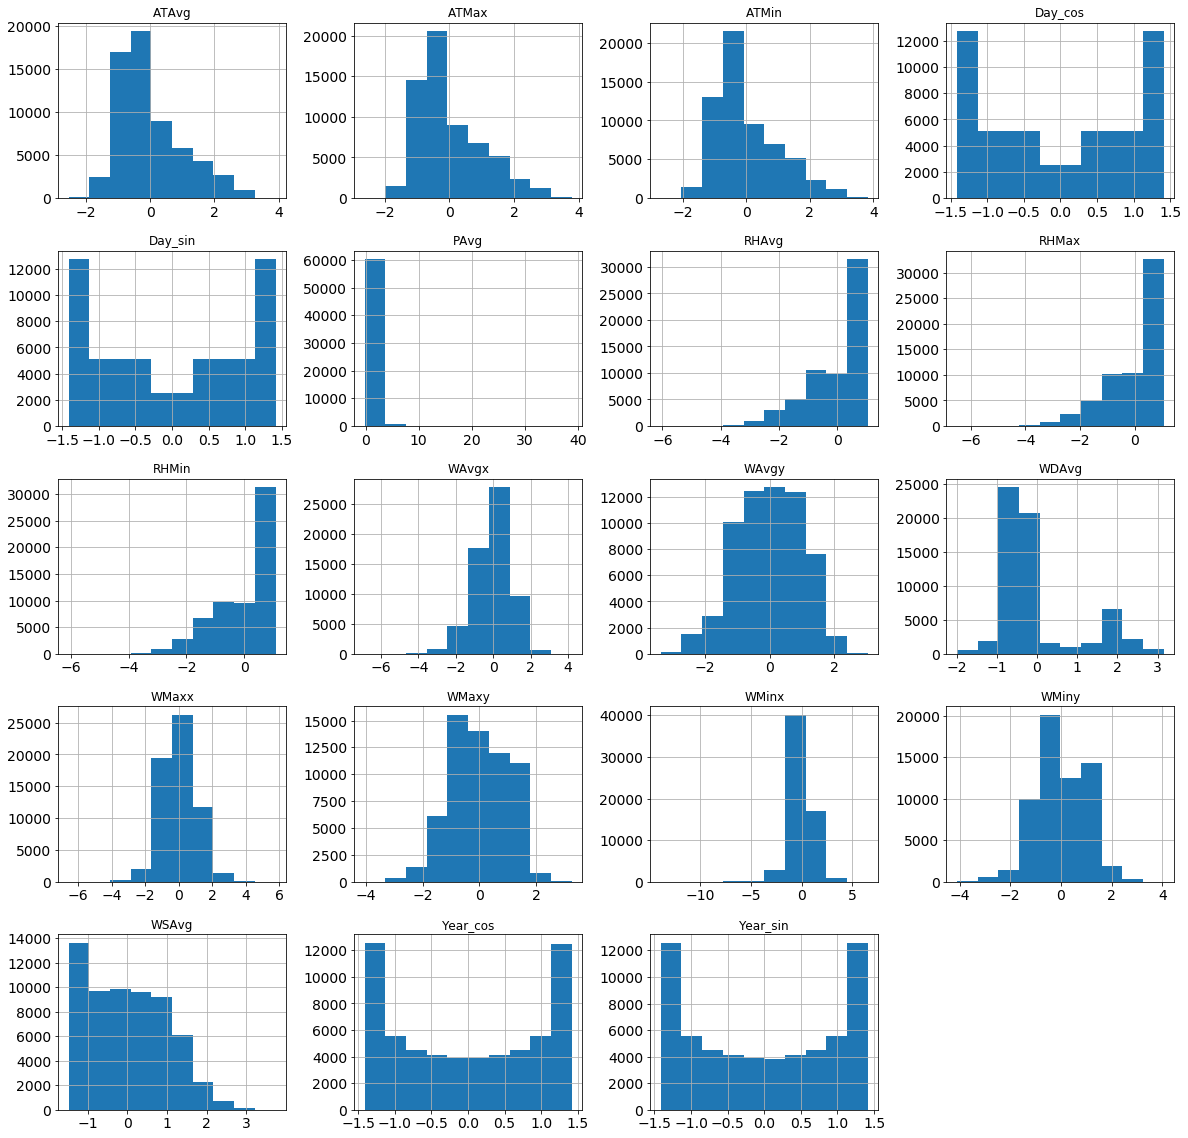

In [7]:
df_scaled.hist(figsize=(20, 20),xlabelsize =14, ylabelsize =14)
plt.savefig(f'data/PROCESSED/STATIONS_CLEAN/banos_histogram_scaled.png', dpi = 100,bbox_inches='tight')

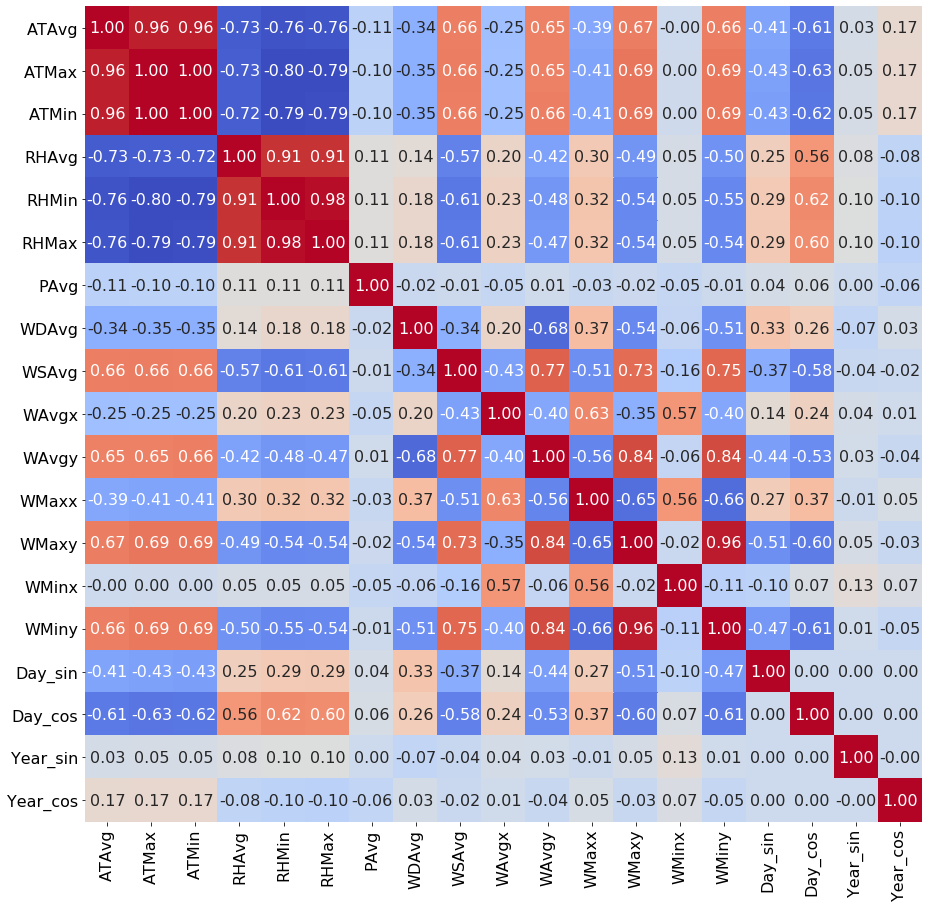

In [38]:
## correlations matrix of variables
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(df.corr(), annot=True, fmt='.2f', 
        cmap='coolwarm', cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig.savefig(f'data/PROCESSED/STATIONS_CLEAN/banos_corrmatrix_all_vars.png',dpi = 75)

### Amount of data of each type of freezing

In [39]:
results =pd.read_csv(f'data/PROCESSED/STATIONS_CLEAN/all_selected_variables.csv')

In [40]:
results.head()

,Date_Time,ATAvg_gua,RHAvg_gua,WSAvg_gua,WAvgx_gua,Day_sin_gua,Day_cos_gua,ATAvg_ban,RHAvg_ban,WSAvg_ban,...,WSAvg_pis,WAvgx_pis,Day_sin_pis,Day_cos_pis,ATAvg_cun,RHAvg_cun,WSAvg_cun,WAvgx_cun,Day_sin_cun,Day_cos_cun
0,2013-05-09 11:45:00,21.708,55.150,4.195,-4.191908,6.540313e-02,-0.997859,23.982,61.768,4.765,...,4.63,-3.217721,6.540313e-02,-0.997859,17.55,64.24,4.21,-2.411445,6.540313e-02,-0.997859
1,2013-05-09 11:50:00,21.728,53.284,4.195,-4.191908,4.361939e-02,-0.999048,24.292,60.124,4.765,...,4.02,-2.793788,4.361939e-02,-0.999048,17.59,62.67,4.22,-2.417173,4.361939e-02,-0.999048
2,2013-05-09 11:55:00,22.090,51.676,4.195,-4.191908,2.181489e-02,-0.999762,24.532,59.028,4.765,...,4.36,-3.030079,2.181489e-02,-0.999762,17.69,63.43,4.29,-2.457268,2.181489e-02,-0.999762
3,2013-05-09 12:00:00,22.190,51.590,4.630,-4.629973,1.373671e-12,-1.000000,24.454,59.820,5.060,...,5.79,-3.925430,1.373671e-12,-1.000000,17.74,65.67,4.16,-2.545388,1.373671e-12,-1.000000
4,2013-05-09 12:05:00,22.106,50.402,4.630,-4.629973,-2.181489e-02,-0.999762,24.580,59.690,5.060,...,6.03,-4.088142,-2.181489e-02,-0.999762,17.85,64.45,4.20,-2.569863,-2.181489e-02,-0.999762


In [45]:
var = 'ATAvg'
r = re.compile(f'{var}.*') 
temp = sorted(list(filter(r.match, list(results.columns))))
var = 'RHAvg'
r = re.compile(f'{var}.*') 
rh = sorted(list(filter(r.match, list(results.columns))))

In [48]:
temp

['ATAvg_AJS',
 'ATAvg_JAl',
 'ATAvg_aer',
 'ATAvg_ban',
 'ATAvg_cal',
 'ATAvg_chi',
 'ATAvg_cun',
 'ATAvg_gua',
 'ATAvg_mul',
 'ATAvg_pam',
 'ATAvg_pfc',
 'ATAvg_pis',
 'ATAvg_qui',
 'ATAvg_tas']

In [69]:
frost = {}

all_df = len(results)
for i in range(len(temp)):
    all_frost = len(results[results[temp[i]] < 4])
    black = len(results[(results[temp[i]] < 4) & (results[rh[i]] < 60 )])
    white = len(results[(results[temp[i]] < 4) & (results[rh[i]] > 60) ])
    frost[temp[i]]={
         'all_frost':round(all_frost/all_df*100,3),
         'black':round(black/all_df*100,3),
         'white':round(white/all_df*100,3),
         'allcount':all_df}
    

In [70]:
pd.DataFrame.from_dict(frost, orient='index').to_csv(f'data/PROCESSED/MODEL_OUTPUTS/frost_events_by_station.csv')

In [5]:
pd.read_csv(f'data/PROCESSED/MODEL_OUTPUTS/frost_events_by_station.csv')

,Unnamed: 0,all_frost,black,white,allcount
0,ATAvg_AJS,0.000,0.000,0.000,623263
1,ATAvg_JAl,0.000,0.000,0.000,623263
2,ATAvg_aer,0.000,0.000,0.000,623263
3,ATAvg_ban,0.000,0.000,0.000,623263
4,ATAvg_cal,3.463,0.254,3.209,623263
5,ATAvg_chi,8.946,0.025,8.921,623263
6,ATAvg_cun,0.000,0.000,0.000,623263
7,ATAvg_gua,0.000,0.000,0.000,623263
8,ATAvg_mul,12.893,0.077,12.816,623263
9,ATAvg_pam,5.966,0.000,5.966,623263


### Min/Max avg temoeratures by station

In [6]:
results =pd.read_csv(f'data/PROCESSED/STATIONS_CLEAN/all_selected_variables.csv')

In [8]:
var = 'ATAvg'
r = re.compile(f'{var}.*') 
temp = sorted(list(filter(r.match, list(results.columns))))

In [10]:
results[temp].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATAvg_AJS,623263.0,12.541431,2.691051,5.410,10.73,11.85,14.28,19.600
ATAvg_JAl,623263.0,12.573459,2.811632,4.938,10.63,11.88,14.43,20.130
ATAvg_aer,623263.0,14.131542,3.288174,4.870,11.80,13.23,16.42,23.350
ATAvg_ban,623263.0,17.668533,2.678484,10.240,15.71,16.95,19.35,24.834
ATAvg_cal,623263.0,8.356630,2.554250,1.690,6.67,7.92,9.98,14.970
ATAvg_chi,623263.0,6.680662,2.302059,0.624,5.14,6.32,8.10,12.618
ATAvg_cun,623263.0,13.521344,3.288866,4.396,11.26,12.68,15.82,22.670
ATAvg_gua,623263.0,16.953410,3.380010,7.230,14.52,16.20,19.38,26.660
ATAvg_mul,623263.0,6.099164,2.062610,0.600,4.71,5.82,7.36,11.510
ATAvg_pam,623263.0,6.557303,1.963379,1.280,5.18,6.15,7.76,11.680
